In [23]:
%pylab inline
import gc
import pdet
import fitsio
import galsim
import numpy as np
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn

from fpfs import imgutil
from fpfs import simutil
from fpfs import fpfsBase
wDir=os.path.join(os.environ['homeWrk'],'FPFS2','sim')

Populating the interactive namespace from numpy and matplotlib


/lustre/work/xiangchong.li/ana/miniconda3/envs/cosmosis-mpich/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
ishear =   1
ngal   =   1
rcut   =   16
ngrid  =   64
beg    =   ngrid//2-rcut
end    =   beg+2*rcut
gsigma =   6.*2.*np.pi/64
beta   =   0.75
noiVar =   1e-3

img    =   simutil.make_basic_sim('basicCenter_psf60','g%d-1111' %ishear,2,ny=ngal,nx=ngal,do_write=False)

# PSF
psfData=   pyfits.getdata(os.path.join(wDir,'galaxy_basic_psf60/psf-60.fits'))
npad   =   (ngrid-psfData.shape[0])//2
psfData1=   np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData1.shape[0]==ngrid
psfData2=  psfData1[beg:end,beg:end]
fpTask0=   fpfsBase.fpfsTask(psfData2,beta=beta)
a0     =   fpTask0.measure(img[beg:end,beg:end])

indX    =   np.arange(32,ngrid,64)
indY    =   np.arange(32,ngrid,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
coords['pdet_y']=   np.ravel(inds[0])
coords['pdet_x']=   np.ravel(inds[1])
b0      =   pdet.get_shear_response_rfft(img,psfData1,gsigma=gsigma,\
            coords=coords,thres=0.)
# Noiseless measurements
out0    =   rfn.merge_arrays([a0,b0],flatten=True,usemask=False)
out0D   =   pdet.peak2det(out0)
out0E   =   pdet.fpfsM2E(out0,out0D,const=1000,noirev=False)
del a0,b0

In [22]:
ls ../../../sim/

config/                    galaxy_cosmo_psf60/     src_basicCenter-var0em0/
config-pix-nl1.ini         galaxy_cosmo_psf75/     src_basicCenter-var4em3/
corPre/                    galaxy_cosmo_psf90/     src_basic-var1em3/
galaxy_basicCenter_psf60/  galaxy_small0_psf60/    src_basic-var4em3/
galaxy_basic_psf45/        galaxy_small1_psf60/    src_basic-var7em3/
galaxy_basic_psf60/        galaxy_small2_psf60/    src_cosmoE-var36em4/
galaxy_basic_psf75/        index_repeat_nums.fits  src_cosmo-var36em4/
galaxy_basicShift_psf60/   job_nsim2.log           src_small0-var7em3/
galaxy_cosmoE_psf60/       noise/                  src_small1-var7em3/
galaxy_cosmoE_psf75/       noiVar_rPsf_sim.csv     src_small2-var7em3/
galaxy_cosmoE_psf90/       plot/                   src_star-var7em3/
galaxy_cosmo_psf105/       repositoryCfg.yaml      star_psf60/
galaxy_cosmo_psf45/        runSim.py*              test_noisy_gals.py


0.7340361


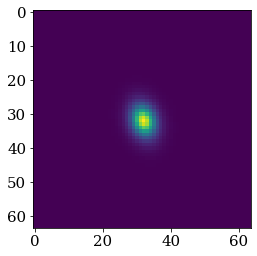

In [3]:
plt.imshow(img)
print(np.max(img))

In [4]:
powIn  =   np.load(os.path.join(wDir,'corPre/noiPows2.npy'),allow_pickle=True).item()['%s'%rcut]*noiVar*100
powModel=  np.zeros((1,powIn.shape[0],powIn.shape[1]))
powModel[0]=powIn
fpTask =   fpfsBase.fpfsTask(psfData2,noiFit=powModel[0],beta=beta,det_gsigma=gsigma)

imgAll=np.tile(img,(100,100))
ngrid2 =   ngrid*100
npad   =   (ngrid2-psfData.shape[0])//2
psfData3=  np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData3.shape[0]==ngrid2

indX    =   np.arange(32,ngrid2,64)
indY    =   np.arange(32,ngrid2,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
coords['pdet_y']=   np.ravel(inds[0])
coords['pdet_x']=   np.ravel(inds[1])

In [26]:
fname= 'src_basicCenter-var1em3_test_0_50.fits'
if not os.path.isfile(fname):
    outAll=[]
    for ifield in range(50):
        noiFname=   os.path.join(wDir,'noise','noi%04d.fits' %ifield)
        # multiply by 10 since the noise has variance 0.01
        noiData=    pyfits.open(noiFname)[0].data*10.*np.sqrt(noiVar)
        imgTmp =    imgAll+noiData
        # Also times 100 for the noivar model
        # Noisy measurements
        b       =   pdet.get_shear_response_rfft(imgTmp,psfData3,gsigma=gsigma,\
                    coords=coords,thres=np.sqrt(noiVar)*0.)
        imgList =   [imgTmp[cc['pdet_y']-rcut:cc['pdet_y']+rcut,\
                    cc['pdet_x']-rcut:cc['pdet_x']+rcut] for cc in b]
        a       =   fpTask.measure(imgList)
        out     =   rfn.merge_arrays([a,b],flatten=True,usemask=False)
        outAll.append(out)
        del a,b,imgList,out,imgTmp,noiData 
        gc.collect()
    out=    rfn.stack_arrays(outAll,usemask=False)
    fitsio.write(fname,out)
    del outAll
    gc.collect()
else:
    out=fitsio.read(fname)

In [27]:
outD=   pdet.peak2det(out)
outE=   pdet.fpfsM2E(out,outD,const=1000,noirev=True)
outEUC= pdet.fpfsM2E(out,outD,const=1000)

In [28]:
for (j,i) in pdet._default_inds:
    print(j,i)
    print(np.average(outE['fpfs_e1v%d%dr1' %(j,i)]-out0E['fpfs_e1v%d%dr1'%(j,i)]))
    print(np.average(outE['fpfs_e2v%d%dr2' %(j,i)]-out0E['fpfs_e2v%d%dr2'%(j,i)]))

1 2
-1.5793873928666e-05
1.0755600711777463e-05
2 1
-1.638782017143255e-05
1.4214745341867916e-05
2 2
3.2471747582774873e-06
1.3588547427601973e-05
2 3
3.4585054573915545e-05
-1.1339302323833837e-06
3 2
-2.5284333449123397e-06
1.4258254842065895e-05


In [29]:
for (j,i) in pdet._default_inds:
    print(j,i)
    print(np.average(outEUC['fpfs_e1v%d%dr1'%(j,i)]-out0E['fpfs_e1v%d%dr1'%(j,i)]))
    print(np.average(outEUC['fpfs_e2v%d%dr2'%(j,i)]-out0E['fpfs_e2v%d%dr2'%(j,i)]))

1 2
-1.818575666015125e-05
5.617576559004578e-06
2 1
-2.0235917835396575e-05
1.221717208799091e-05
2 2
0.00010588961032626334
0.00011243638364441408
2 3
3.074368559802994e-05
-3.1359513938401456e-06
3 2
-4.927041076118789e-06
9.119992273115508e-06


In [30]:
print(np.average(outE['fpfs_e1']-out0E['fpfs_e1']))
print(np.average(outE['fpfs_e2']-out0E['fpfs_e2']))

4.884967163809997e-06
1.4517019546934717e-05


In [31]:
print(np.average(outEUC['fpfs_e1']-out0E['fpfs_e1']))
print(np.average(outEUC['fpfs_e2']-out0E['fpfs_e2']))

6.9018436818863405e-06
1.204925069755229e-05


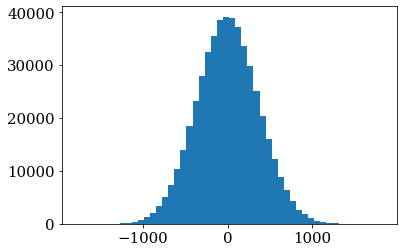

In [32]:
name='fpfs_M00'
_=plt.hist(out[name]-out0[name],bins=50)

In [33]:
name1='fpfs_M00'
name2='fpfs_M00'
name3='fpfs_N00N00'
print(np.average((out[name2]-out0[name2])*(out[name1]-out0[name1])))
print(np.average(out[name3]))

132081.02784529558
138300.34645823154


In [34]:
for ind in pdet._default_inds:
    name1='fpfs_M22c'
    name2='pdet_v%d%dr1' %ind
    name3='pdet_N22cV%d%dr1' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))
for ind in pdet._default_inds:
    name1='fpfs_M00'
    name2='pdet_v%d%dr1' %ind
    name3='pdet_N00V%d%dr1' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

-0.01775065963758589
-0.02438780362687274
-0.14903316790994425
-0.09971806714615808
2.0199468103529488
1.9909584824139408
-0.07856220431041286
-0.09959854399779405
-0.013332508359622991
-0.0245155601162901
0.21964735036768324
0.15632123088052507
-0.19318551321200061
-0.1784825233272947
0.25897333590706206
0.2128451209514682
-0.14138667490367302
-0.1784726696141995
0.16840722709095146
0.15630413427003778


In [35]:
for ind in pdet._default_inds:
    name1='fpfs_M22s'
    name2='pdet_v%d%dr2' %ind
    name3='pdet_N22sV%d%dr2' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

-0.08764870124353963
-0.09967972083365365
-0.00868626142197375
-0.03958207546821485
1.9097718753109527
1.9020111023805297
-0.049222309426448334
-0.03965858434736586
-0.09399239373894772
-0.09967646186338786


In [15]:
for ind in pdet._default_inds:
    print(ind)
    name1='fpfs_M00'
    name2='pdet_v%d%dr2' %ind
    name3='pdet_N00V%d%dr2' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

(1, 2)
-0.0006958884334311217
0.010849829564706235
(2, 1)
-0.012616563803849498
0.005251158694865625
(2, 2)
-0.14683109285777404
-0.14623184337631065
(2, 3)
0.012186259328434328
0.005266566567611996
(3, 2)
0.01352823725041311
0.010782706988388407


In [16]:
for ind in pdet._default_inds:
    print(ind)
    name1='fpfs_M00'
    name2='pdet_v%d%dr1' %ind
    name3='pdet_N00V%d%dr1' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

(1, 2)
0.21964735036768324
0.15632123088052507
(2, 1)
-0.19318551321200061
-0.1784825233272947
(2, 2)
0.25897333590706206
0.2128451209514682
(2, 3)
-0.14138667490367302
-0.1784726696141995
(3, 2)
0.16840722709095146
0.15630413427003778


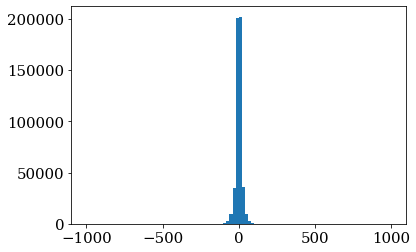

In [17]:
_=plt.hist((outD[name2]-out0D[name2])*(out[name1]-out0[name1]),bins=100,range=(-1000,1000))